# Deep Q-Learning 

Install dependencies for AI gym to run properly (shouldn't take more than a minute). If running on google cloud or running locally, only need to run once. Colab may require installing everytime the vm shuts down.

In [9]:
!pip3 install gym pyvirtualdisplay
!sudo apt-get install -y xvfb python-opengl ffmpeg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:4.2.7-0ubuntu0.1).
The following additional packages will be installed:
  freeglut3 libfontenc1 libpython2-stdlib libxfont2 libxkbfile1 python2
  python2-minimal x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common
Suggested packages:
  python-tk python-numpy libgle3 python2-doc
The following NEW packages will be installed:
  freeglut3 libfontenc1 libpython2-stdlib libxfont2 libxkbfile1 python-opengl
  python2 python2-minimal x11-xkb-utils xfonts-base xfonts-encodings
  xfonts-utils xserver-common xvfb
0 upgraded, 14 newly installed, 0 to remove and 24 not upgraded.
Need to get 8,318 kB of archives.
After this operation, 18.0 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 python2-m

In [10]:
!pip3 install --upgrade setuptools --user
!pip3 install ez_setup 
!pip3 install gym[atari] 
!pip3 install autorom[accept-rom-license]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 52.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for ez_setup: filename=ez_setup-0.9-py3-none-any.whl size=11012 sha256=95df4cccb0ee41b6da442c3234d9fd726f5c2bd59e77d2e8e658c777c08ccdd5
  Stored in directory: /root/.cache/pip/wheels/d7/39/49/e7ce9ce92f074adc6f755a0cc05992407730e14d94ce3f9554
Successfully built ez_setup
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 68.9

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 32.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.6.1-py3-none-any.whl size=446676 sha256=cc3e7e92f2d3133d09e4c04ca7aca831ca1472434006f6e4489ab96f76a570e8
  Stored in directory: /root/.cache/pip/wheels/b1/1f/f7/2da07cf4f81ea264bdaf043028749d88fe0c2227134a22cf80
Successfully built AutoROM.accept-rom-license


In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [3]:
import os

os.chdir("/content/gdrive/MyDrive/DRL_747_Clone")

For this assignment we will implement the Deep Q-Learning algorithm with Experience Replay as described in breakthrough paper __"Playing Atari with Deep Reinforcement Learning"__. We will train an agent to play the famous game of __Breakout__.

In [4]:
%matplotlib inline

import sys
import gym
import torch
import pylab
import random
import numpy as np
from collections import deque
from datetime import datetime
from copy import deepcopy
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from model import DQN
from utils import find_max_lives, check_live, get_frame, get_init_state
from config import *

import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 1
%aimport agent
%aimport agent_double
%aimport config

## Understanding the environment

In the following cell, we initialize our game of __Breakout__ and you can see how the environment looks like. For further documentation of the of the environment refer to https://gym.openai.com/envs. 

In breakout, we will use 3 actions "fire", "left", and "right". "fire" is only used to reset the game when a life is lost, "left" moves the agent left and "right" moves the agent right.

In [11]:
env = gym.make('BreakoutDeterministic-v4')
state = env.reset()

NameNotFound: ignored

In [7]:
number_lives = find_max_lives(env)
state_size = env.observation_space.shape
action_size = 3 #fire, left, and right

NameError: ignored

## Creating a DQN Agent

Here we create a DQN Agent. This agent is defined in the __agent.py__. The corresponding neural network is defined in the __model.py__. Once you've created a working DQN agent, use the code in agent.py to create a double DQN agent in __agent_double.py__. Set the flag "double_dqn" to True to train the double DQN agent.

__Evaluation Reward__ : The average reward received in the past 100 episodes/games.

__Frame__ : Number of frames processed in total.

__Memory Size__ : The current size of the replay memory.

In [22]:
double_dqn = False # set to True if using double DQN agent

if double_dqn:
    from agent_double import Agent
    model_type = "double_dqn"
else:
    from agent import Agent
    model_type = "deep_qn"

agent = Agent(action_size)
evaluation_reward = deque(maxlen=evaluation_reward_length)
frame = 0
memory_size = 0

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Main Training Loop

In this training loop, we do not render the screen because it slows down training signficantly. To watch the agent play the game, run the code in next section "Visualize Agent Performance"

Here, we do not report the entire training history. For this history, please see the attached notebook. Rather, we only showcase the final plots from training both vanilla DQN and DDQN networks for the Breakout task.

In [ ]:
rewards, episodes = [], []
best_eval_reward = 0
for e in range(EPISODES):
    done = False
    score = 0

    history = np.zeros([5, 84, 84], dtype=np.uint8)
    step = 0
    d = False
    state = env.reset()
    next_state = state
    life = number_lives

    get_init_state(history, state)

    while not done:
        step += 1
        frame += 1

        # Perform a fire action if ball is no longer on screen to continue onto next life
        if step > 1 and len(np.unique(next_state[:189] == state[:189])) < 2:
            action = 0
        else:
            action = agent.get_action(np.float32(history[:4, :, :]) / 255.)
        state = next_state
        next_state, reward, done, info = env.step(action + 1)
        
        frame_next_state = get_frame(next_state)
        history[4, :, :] = frame_next_state
        terminal_state = check_live(life, info['lives'])

        life = info['lives']
        r = np.clip(reward, -1, 1) 
        r = reward

        # Store the transition in memory 
        agent.memory.push(deepcopy(frame_next_state), action, r, terminal_state)
        # Start training after random sample generation
        if(frame >= train_frame):
            # print(train_frame, frame)
            agent.train_policy_net(frame)
            # Update the target network only for Double DQN only
            if double_dqn and (frame % update_target_network_frequency)== 0:
                agent.update_target_net()
        score += reward
        history[:4, :, :] = history[1:, :, :]
            
        if done:
            evaluation_reward.append(score)
            rewards.append(np.mean(evaluation_reward))
            episodes.append(e)
            pylab.plot(episodes, rewards, 'b')
            pylab.xlabel('Episodes')
            pylab.ylabel('Rewards') 
            pylab.title('Episodes vs Reward')
            pylab.savefig(f"./save_graph/breakout_{model_type}.png") # save graph for training visualization
            
            # every episode, plot the play time
            print("episode:", e, "  score:", score, "  memory length:",
                  len(agent.memory), "  epsilon:", agent.epsilon, "   steps:", step,
                  "   lr:", agent.optimizer.param_groups[0]['lr'], "    evaluation reward:", np.mean(evaluation_reward))

            # if the mean of scores of last 100 episode is bigger than 5 save model
            ### Change this save condition to whatever you prefer ###
            if np.mean(evaluation_reward) > 5 and np.mean(evaluation_reward) > best_eval_reward:
                torch.save(agent.policy_net.state_dict(), f"./save_model/breakout_{model_type}.pth")
                best_eval_reward = np.mean(evaluation_reward)


episode: 0   score: 0.0   memory length: 124   epsilon: 1.0    steps: 124    lr: 0.0001     evaluation reward: 0.0
episode: 1   score: 0.0   memory length: 248   epsilon: 1.0    steps: 124    lr: 0.0001     evaluation reward: 0.0
episode: 2   score: 1.0   memory length: 418   epsilon: 1.0    steps: 170    lr: 0.0001     evaluation reward: 0.3333333333333333
episode: 3   score: 4.0   memory length: 680   epsilon: 1.0    steps: 262    lr: 0.0001     evaluation reward: 1.25
episode: 4   score: 1.0   memory length: 852   epsilon: 1.0    steps: 172    lr: 0.0001     evaluation reward: 1.2
episode: 5   score: 0.0   memory length: 976   epsilon: 1.0    steps: 124    lr: 0.0001     evaluation reward: 1.0
episode: 6   score: 0.0   memory length: 1100   epsilon: 1.0    steps: 124    lr: 0.0001     evaluation reward: 0.8571428571428571
episode: 7   score: 2.0   memory length: 1319   epsilon: 1.0    steps: 219    lr: 0.0001     evaluation reward: 1.0
episode: 8   score: 3.0   memory length: 1566  

/content/gdrive/MyDrive/DRL_747_Clone/memory.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sample = np.array(sample)
/content/gdrive/MyDrive/DRL_747_Clone/agent.py:77: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mini_batch = np.array(mini_batch).transpose()


episode: 551   score: 4.0   memory length: 100201   epsilon: 0.9996000400000087    steps: 297    lr: 0.0001     evaluation reward: 1.37
episode: 552   score: 3.0   memory length: 100449   epsilon: 0.9991090000000193    steps: 248    lr: 0.0001     evaluation reward: 1.4
episode: 553   score: 2.0   memory length: 100667   epsilon: 0.9986773600000287    steps: 218    lr: 0.0001     evaluation reward: 1.42
episode: 554   score: 0.0   memory length: 100790   epsilon: 0.998433820000034    steps: 123    lr: 0.0001     evaluation reward: 1.42
episode: 555   score: 3.0   memory length: 101021   epsilon: 0.9979764400000439    steps: 231    lr: 0.0001     evaluation reward: 1.43
episode: 556   score: 4.0   memory length: 101316   epsilon: 0.9973923400000566    steps: 295    lr: 0.0001     evaluation reward: 1.47
episode: 557   score: 2.0   memory length: 101515   epsilon: 0.9969983200000652    steps: 199    lr: 0.0001     evaluation reward: 1.46
episode: 558   score: 4.0   memory length: 101791 

## Training data for DQN 

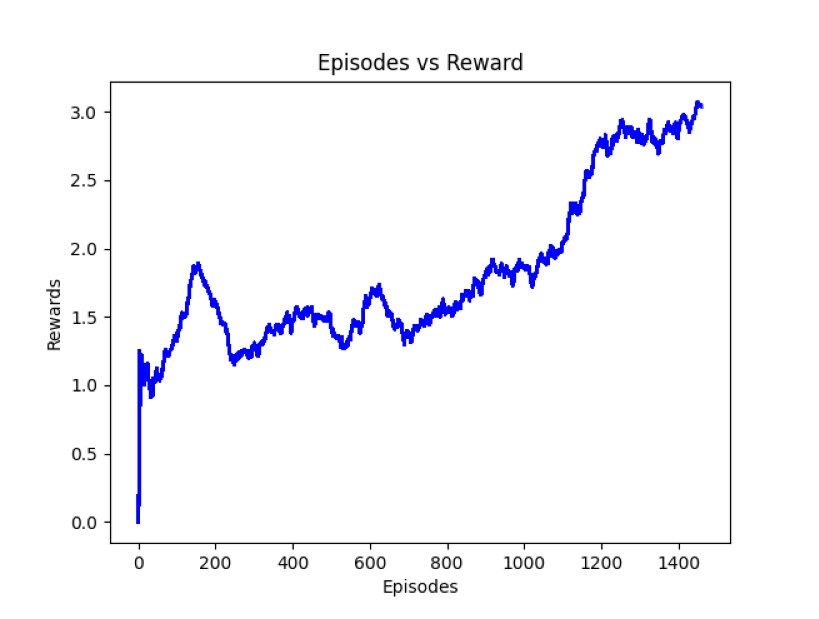

In [14]:

import matplotlib.image as mpimg
fig = plt.figure(figsize=(8,8))
ax = fig.add_axes([0, 0, 1, 1], frameon=False)
ax.margins(0)
ax.set_xticks([])
ax.set_yticks([])
img = mpimg.imread('./save_graph/breakout_deep_qn.png')
pylab.imshow(img)

## Training data for DDQN 

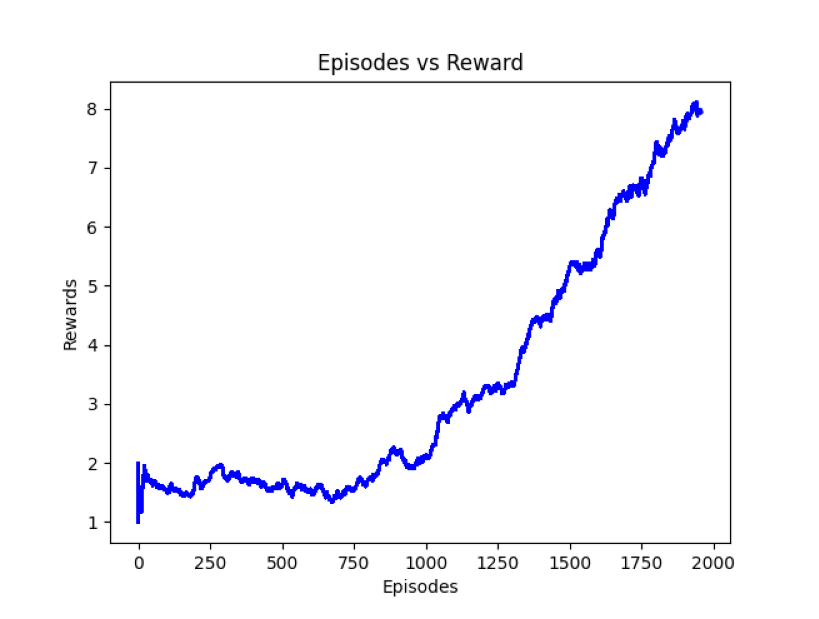

In [12]:
import matplotlib.image as mpimg
fig = plt.figure(figsize=(8,8))
ax = fig.add_axes([0, 0, 1, 1], frameon=False)
ax.margins(0)
ax.set_xticks([])
ax.set_yticks([])
img = mpimg.imread('./save_graph/breakout_double_dqn.png')
pylab.imshow(img)

# Visualize Agent Performance

BE AWARE THIS CODE BELOW MAY CRASH THE KERNEL IF YOU RUN THE SAME CELL TWICE.

Please save your model before running this portion of the code.

In [20]:
if True:
  torch.save(agent.policy_net.state_dict(), f"./save_model/breakout_{model_type}_latest.pth")

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from gym.wrappers import Monitor
import glob
import io
import base64

from IPython.display import HTML
from IPython import display as ipythondisplay

from pyvirtualdisplay import Display

# Displaying the game live
def show_state(env, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("%s | Step: %d %s" % ("Agent Playing",step, info))
    plt.axis('off')

    ipythondisplay.clear_output(wait=True)
    ipythondisplay.display(plt.gcf())
    
# Recording the game and replaying the game afterwards
def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else: 
        print("Could not find video")
    

def wrap_env(env):
    env = Monitor(env, './video', force=True)
    return env

In [ ]:
display = Display(visible=0, size=(300, 200))
display.start()

# Load agent
agent.load_policy_net(f"./save_model/breakout_{model_type}_latest.pth")
agent.epsilon = 0.0 # Set agent to only exploit the best action

env = gym.make('BreakoutDeterministic-v4')
env = wrap_env(env)

done = False
score = 0
step = 0
state = env.reset()
next_state = state
life = number_lives
history = np.zeros([5, 84, 84], dtype=np.uint8)
get_init_state(history, state)

while not done:
    
    # Render breakout
    env.render()
#     show_state(env,step) # uncommenting this provides another way to visualize the game

    step += 1
    frame += 1

    # Perform a fire action if ball is no longer on screen
    if step > 1 and len(np.unique(next_state[:189] == state[:189])) < 2:
        action = 0
    else:
        action = agent.get_action(np.float32(history[:4, :, :]) / 255.)
    state = next_state
    
    next_state, reward, done, info = env.step(action + 1)
        
    frame_next_state = get_frame(next_state)
    history[4, :, :] = frame_next_state
    terminal_state = check_live(life, info['ale.lives'])
        
    life = info['ale.lives']
    r = np.clip(reward, -1, 1) 
    r = reward

    # Store the transition in memory 
    agent.memory.push(deepcopy(frame_next_state), action, r, terminal_state)
    # Start training after random sample generation
    score += reward
    
    history[:4, :, :] = history[1:, :, :]
env.close()
show_video()
display.stop()